In [4]:
import torch
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaForMaskedLM
from datasets import load_dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
# Load dataset
dataset_test = load_dataset("ag_news", split="test")

# Allocate GPU
device = torch.device("cuda:4")

# Initialize the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
model_1 = RobertaForMaskedLM.from_pretrained('roberta-large').to(device) 
model_2 = RobertaForMaskedLM.from_pretrained('KomeijiForce/roberta-large-pseudo-mlm').to(device)

In [6]:
# return a prob for the masked position given the text parsed in (parse text contains mask)
def masked_logits(text):

    # Tokenize the input text
    text_tokens = [tokenizer.cls_token] + tokenizer.tokenize(text) + [tokenizer.sep_token]

    # Convert tokens to input tensor format
    input_ids = tokenizer.convert_tokens_to_ids(text_tokens)
    input_tensor = torch.tensor([input_ids]).to(device)
    
    # Get the output logits from the model
    # Gradients not needed since this is an inference not a training
    with torch.no_grad():
        outputs = model_1(input_tensor)
        predictions = outputs.logits

    # Extract the logits for the masked position
    masked_position = input_ids.index(tokenizer.mask_token_id)
    masked_logits = predictions[0, masked_position, :]

    # Calculate probabilities of masked_logits
    probabilities = F.softmax(masked_logits, dim=-1)

    return probabilities

In [7]:
# Return a tensor of probs at all positions from masks of all positions 
def get_masked_logits(text, batch_size=8):

    # Tokenize the input text
    text_tokens = tokenizer.tokenize(text)

    all_probabilities = []

    # Create masked texts with each position masked by the mask token
    masked_texts = [tokenizer.convert_tokens_to_string(text_tokens[:i] + [tokenizer.mask_token] + text_tokens[i+1:]) for i in range(len(text_tokens))]

    for idx in range(0, len(masked_texts), batch_size):

        masked_texts_batch = masked_texts[idx:idx+batch_size]

        # Tokenize the masked texts
        input_dict = tokenizer(masked_texts_batch, padding=True, return_tensors='pt', truncation=True)

        input_dict = input_dict.to(device)

        # Pass the tokenized data through the model
        masked_logits = model_2(**input_dict).logits

        # Identify which positions in the input are masked
        # mask_positions = torch.where(input_dict["input_ids"] == tokenizer.mask_token_id)[1]  # Get the column indices

        # Extract the logits corresponding to the masked positions
        # masked_logits = torch.stack([logits[i, mask_positions[i], :] for i in range(logits.shape[0])])

        # Calculate probabilities at each position
        probabilities = F.softmax(masked_logits, dim=-1)

        # Stack all probabilities
        all_probabilities.append(probabilities)

    return torch.cat(all_probabilities)

In [8]:
# Function to compute the KL divergence
def kl_divergence(p, q):
    """Compute KL Divergence between two probability distributions."""
    return torch.sum(p * (p / q).log(), dim=-1)

In [9]:
# Precompute logits for the baseline text (text_p)
text_p = "Sports term:" + tokenizer.mask_token + "."
logits_p = masked_logits(text_p).unsqueeze(0)

In [10]:
# Compute KL divergence for every text in the dataset
kls = []
labels = []

with torch.no_grad():
    for example in tqdm(dataset_test):
        text_q = example['text']
        labels.append(example['label'])
        logits_q = get_masked_logits(text_q, batch_size=512)
        kls.append(kl_divergence(logits_p, logits_q).amin(0).item()) 

  0%|          | 0/7600 [00:00<?, ?it/s]

RuntimeError: a Tensor with 37 elements cannot be converted to Scalar

In [ ]:
# logits_p.argsort(-1).flip(-1)

In [ ]:
# vocab = tokenizer.get_vocab()
# vocab = {vocab[v]:v for v in vocab}
# for idx in logits_p.argsort(-1).flip(-1)[0, :20]:
#     print(vocab[idx.item()])

In [ ]:
# np.argsort(kls)

In [ ]:
sorted_labels = [labels[idx] for idx in np.argsort(kls)]
sorted_labels

In [4]:
def find_accur(label_num):
    # Calculate 5% of the total number of labels
    total_labels = len(sorted_labels)
    five_perc = int(total_labels * 0.05)
    granular_range = int(five_perc * 0.01)
    perc_accuracy = []
    
    for i in range(0, five_perc, granular_range):
        
        # Extract the current segment
        segment = sorted_labels[i:i + granular_range]
        
        # Check if label is 1
        correct_predictions = sum(1 for label in segment if label == label_num)
        accuracy = correct_predictions / len(segment) if segment else 0
        
        # Append the accuracy to perc_accuracy
        perc_accuracy.append(accuracy)
    
    # Create a list of percentiles for the 5% range
    percentiles = [(i / five_perc) * 5 for i in range(0, five_perc, granular_range)]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=percentiles, y=perc_accuracy)
    
    # Adding titles and labels
    plt.title("Model Accuracy in the First 5%")
    plt.xlabel("Percentile (up to 5%)")
    plt.ylabel("Accuracy")
    
    # Show the plot
    plt.show()

In [ ]:
find_accur(1)

In [18]:
# Precompute logits for the baseline text (World)
text_p = "Political term:" + tokenizer.mask_token + "."
logits_p = masked_logits(text_p).unsqueeze(0)

In [13]:
# Compute KL divergence for every text in the dataset
kls = []
labels = []

with torch.no_grad():
    for example in tqdm(dataset_test):
        text_q = example['text']
        labels.append(example['label'])
        logits_q = get_masked_logits(text_q, batch_size=512)
        kls.append(kl_divergence(logits_p, logits_q).amin(0).item()) 

  0%|          | 0/7600 [00:00<?, ?it/s]

In [16]:
sorted_labels = [labels[idx] for idx in np.argsort(kls)]
sorted_labels

[1,
 1,
 3,
 1,
 1,
 0,
 0,
 0,
 3,
 0,
 3,
 0,
 3,
 2,
 0,
 3,
 2,
 2,
 2,
 0,
 0,
 3,
 2,
 0,
 3,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 0,
 1,
 3,
 1,
 3,
 0,
 2,
 1,
 0,
 3,
 2,
 0,
 2,
 3,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 3,
 1,
 0,
 3,
 3,
 0,
 3,
 1,
 0,
 3,
 2,
 2,
 2,
 1,
 0,
 3,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 3,
 0,
 3,
 3,
 3,
 1,
 2,
 3,
 3,
 0,
 3,
 3,
 3,
 0,
 0,
 3,
 1,
 1,
 2,
 2,
 2,
 0,
 3,
 0,
 2,
 3,
 0,
 3,
 2,
 0,
 0,
 2,
 2,
 1,
 3,
 0,
 0,
 0,
 1,
 1,
 3,
 1,
 3,
 0,
 3,
 0,
 2,
 3,
 0,
 2,
 2,
 1,
 2,
 1,
 0,
 2,
 1,
 2,
 3,
 2,
 1,
 1,
 0,
 0,
 3,
 3,
 0,
 2,
 1,
 0,
 3,
 1,
 1,
 3,
 2,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 0,
 2,
 3,
 1,
 2,
 0,
 0,
 0,
 2,
 3,
 1,
 2,
 2,
 3,
 2,
 3,
 2,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 2,
 3,
 0,
 1,
 2,
 2,
 3,
 3,
 0,
 0,
 0,
 1,
 0,
 3,
 2,
 1,
 2,
 2,
 0,
 3,
 1,
 0,
 1,
 1,
 3,
 1,
 0,
 1,
 2,
 0,
 0,
 3,
 1,
 1,
 3,
 3,
 3,
 3,
 1,
 3,
 1,
 0,
 1,
 2,
 2,
 0,
 3,
 1,
 1,


In [3]:
find_accur(0)

NameError: name 'sorted_labels' is not defined

In [24]:
# Precompute logits for the baseline text (Business)
text_p = "Business term:" + tokenizer.mask_token + "."
logits_p = masked_logits(text_p).unsqueeze(0)

In [25]:
# Compute KL divergence for every text in the dataset
kls = []
labels = []

with torch.no_grad():
    for example in tqdm(dataset_test):
        text_q = example['text']
        labels.append(example['label'])
        logits_q = get_masked_logits(text_q, batch_size=512)
        kls.append(kl_divergence(logits_p, logits_q).amin(0).item()) 

  0%|          | 0/7600 [00:00<?, ?it/s]

In [26]:
sorted_labels = [labels[idx] for idx in np.argsort(kls)]
sorted_labels

[3,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 3,
 2,
 3,
 1,
 3,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 1,
 2,
 2,
 3,
 3,
 3,
 1,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 3,
 2,
 3,
 3,
 3,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 2,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 3,
 3,
 2,
 1,
 3,
 3,
 3,
 3,
 2,
 0,
 3,
 3,
 2,
 2,
 2,
 3,
 1,
 3,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 3,
 0,
 3,
 2,
 2,
 0,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 0,
 3,
 1,
 3,
 3,
 3,
 2,
 3,
 1,
 2,
 2,
 3,
 2,
 2,
 1,
 1,
 1,
 2,
 3,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 1,
 3,
 2,
 1,
 2,
 3,
 3,
 3,
 1,
 1,
 1,
 0,
 3,
 1,
 3,
 3,
 2,
 3,
 2,
 3,
 3,
 0,
 2,
 1,
 2,
 3,
 2,
 3,
 3,
 2,
 2,
 3,
 2,
 2,
 1,
 3,
 0,
 1,
 3,
 3,
 2,
 2,
 2,
 3,
 3,
 2,
 2,
 3,
 0,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 1,
 3,
 2,
 2,
 2,
 3,
 0,
 2,
 1,
 2,
 3,
 3,
 2,
 3,
 2,
 2,
 3,
 3,
 3,
 2,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 3,


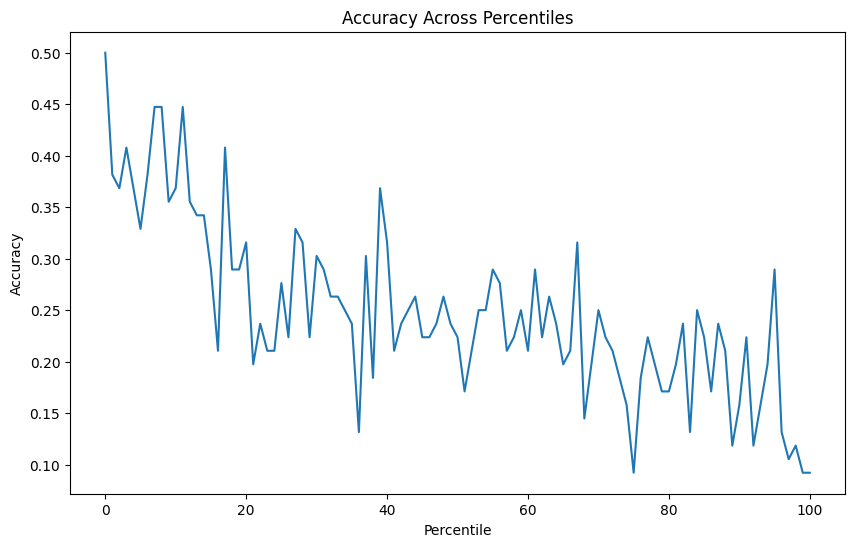

In [27]:
find_accur(2)

In [29]:
# Precompute logits for the baseline text (Sci/Tech)
text_p = "Technology term:" + tokenizer.mask_token + "."
logits_p = masked_logits(text_p).unsqueeze(0)

In [30]:
# Compute KL divergence for every text in the dataset
kls = []
labels = []

with torch.no_grad():
    for example in tqdm(dataset_test):
        text_q = example['text']
        labels.append(example['label'])
        logits_q = get_masked_logits(text_q, batch_size=512)
        kls.append(kl_divergence(logits_p, logits_q).amin(0).item()) 

  0%|          | 0/7600 [00:00<?, ?it/s]

In [31]:
sorted_labels = [labels[idx] for idx in np.argsort(kls)]
sorted_labels

[3,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 1,
 1,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 1,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 2,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 1,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 0,
 3,
 3,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 1,
 0,
 3,
 2,
 2,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,


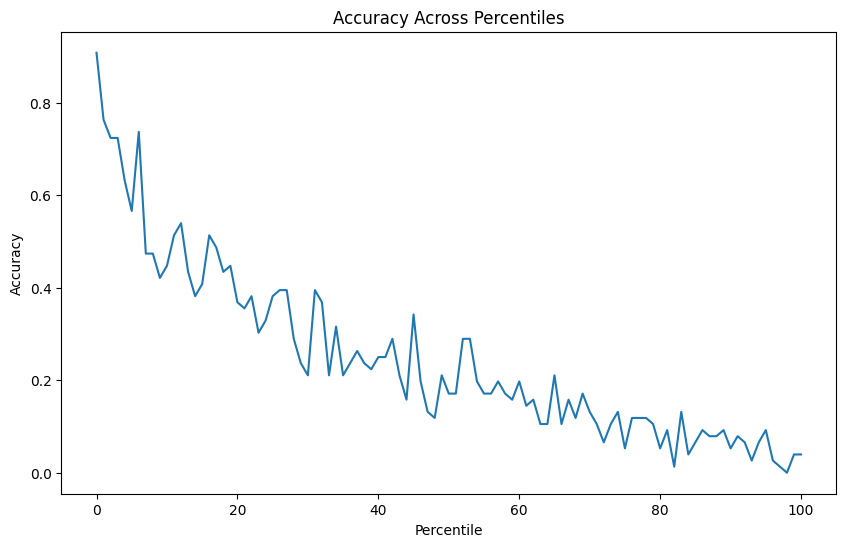

In [32]:
find_accur(3)

In [14]:
# kls

In [15]:
# lengths = [len(tokenizer.tokenize(data["text"])) for data in dataset_test]

In [16]:
# lengths

In [17]:
# plt.scatter(lengths, kls)